In [1]:
import torch
import kornia as K
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
from datetime import datetime
import os
import numpy as np
from pathlib import Path
import scipy.io as sio
import scipy.ndimage as sn
from scipy.ndimage import gaussian_filter
from skimage import filters
from skimage.exposure import rescale_intensity
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

from scipy import ndimage

Using cuda device


In [2]:
url = 'https://res.cloudinary.com/roundglass/image/upload/v1599206051/roundglass/sustain/bengal-slow-loris-ConservationistShutterstock_nliovw.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

basewidth = 800
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)

img = np.array(img) / 255

In [3]:
d_img = torch.Tensor(img).to(device).permute(2, 0, 1).unsqueeze(0)

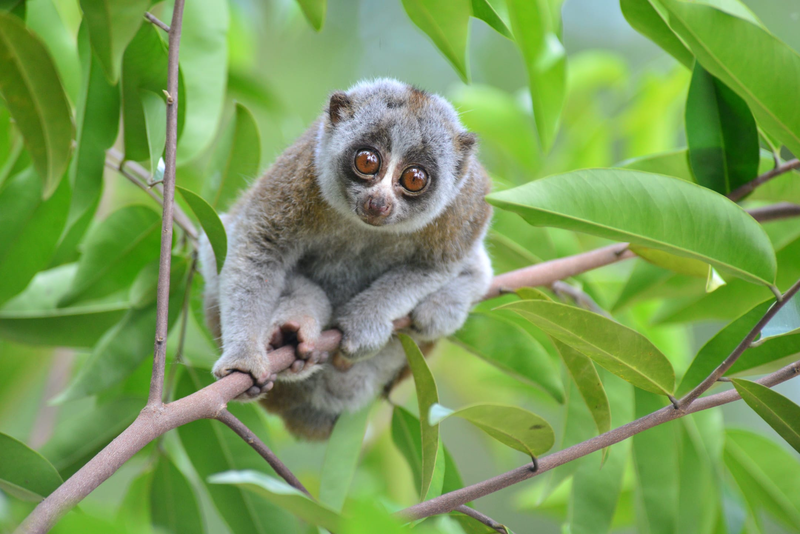

In [4]:
def np_to_img(img):
    img = img.clip(0,1)
    img = (img * 255).astype(np.uint8)
    return Image.fromarray(img, 'RGB')

def tensor_to_image(tensor, mode='RGB'):
    image = tensor.clone().detach()
    image = image.cpu().numpy().squeeze(0)
    image *= 255.
    if mode == 'L':
        image = image.squeeze(0)
    else:
        image = image.transpose(1, 2, 0)
    
    image = image.clip(0,255)
    image = Image.fromarray(image.astype(np.uint8), mode)
    return image

np_to_img(img)

In [16]:
class SmoothWithRegression(torch.nn.Module):
    def __init__(self, img, loss_weights=(1, 1, 1), sigma=2):
        super(SmoothWithRegression, self).__init__()
        self.img = torch.nn.Parameter(data=img.clone(), requires_grad=True)
        self.loss_weights = loss_weights
        self.sigma = sigma 
        
        self.guide_edges = K.filters.Canny(sigma=(self.sigma,self.sigma))(img)[1]
        self.conv_dt = K.contrib.ConvDistanceTransform(33)
        self.guide_edge_dt = self.conv_dt(self.guide_edges)
        
    def loss(self):
        xi_canny =  K.filters.Canny(sigma=(self.sigma,self.sigma))(self.img)[1]
        
        px_gradients = K.filters.sobel(self.img)
        regression_loss = self.guide_edge_dt - self.conv_dt(self.img)
        edge_diff = self.guide_edges - xi_canny
                              
        return px_gradients.mean() + edge_diff.mean() + regression_loss.mean()
        ''
    def forward(self):
        return self.loss()

Loss in iteration 0 of 2000: 8.181
Loss in iteration 50 of 2000: 8.096
Loss in iteration 100 of 2000: 8.018
Loss in iteration 150 of 2000: 7.945
Loss in iteration 200 of 2000: 7.859
Loss in iteration 250 of 2000: 7.767
Loss in iteration 300 of 2000: 7.686
Loss in iteration 350 of 2000: 7.600
Loss in iteration 400 of 2000: 7.523
Loss in iteration 450 of 2000: 7.436
Loss in iteration 500 of 2000: 7.400
Loss in iteration 550 of 2000: 7.402
Loss in iteration 600 of 2000: 7.369
Loss in iteration 650 of 2000: 7.412
Loss in iteration 700 of 2000: 7.371
Loss in iteration 750 of 2000: 7.312
Loss in iteration 800 of 2000: 7.327
Loss in iteration 850 of 2000: 7.294
Loss in iteration 900 of 2000: 7.340
Loss in iteration 950 of 2000: 7.307
Loss in iteration 1000 of 2000: 7.288
Loss in iteration 1050 of 2000: 7.221
Loss in iteration 1100 of 2000: 7.241
Loss in iteration 1150 of 2000: 7.243
Loss in iteration 1200 of 2000: 7.315
Loss in iteration 1250 of 2000: 7.386
Loss in iteration 1300 of 2000: 7.3

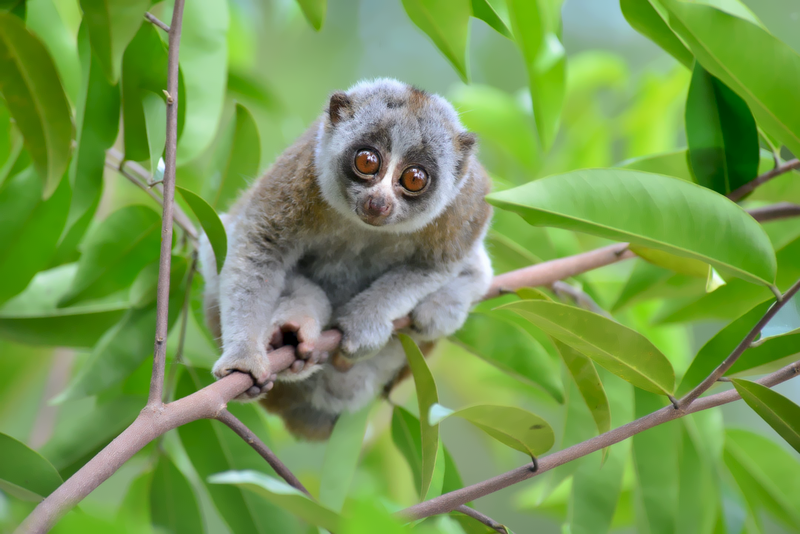

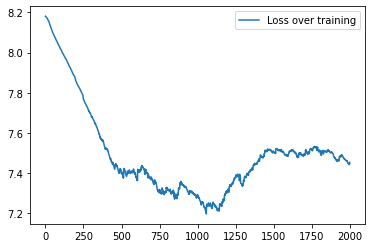

In [17]:
timestamp = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
new_dir = Path(f'C:/Users/aaros/Dropbox/fall quarter 2021/CSCD501/research project/code/notebooks/{timestamp}-notebook-out')
os.makedirs(new_dir)

smoother = SmoothWithRegression(d_img)
loss = None
loss_hist = []
optimizer = torch.optim.SGD(smoother.parameters(), lr=1, momentum=0.9)
num_iters: int = 2000
for i in range(num_iters):
    optimizer.zero_grad()
    loss = smoother()

    if i % 50 == 0:
        print("Loss in iteration {} of {}: {:.3f}".format(i, num_iters, loss.item()))
        save_img = tensor_to_image(smoother.img.clone().detach())
        save_img.save(new_dir / f'img_iter_{i}.png')
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.clone().detach().cpu().numpy())

plt.plot(loss_hist)
plt.legend(['Loss over training', 'Edge loss'])
tensor_to_image(smoother.img, 'RGB')

In [5]:
class SmoothWithOnlyRegression(torch.nn.Module):
    def __init__(self, img, loss_weights=(1, 1, 1), sigma=2):
        super(SmoothWithOnlyRegression, self).__init__()
        self.img = torch.nn.Parameter(data=img.clone(), requires_grad=True)
        self.loss_weights = loss_weights
        self.sigma = sigma 
        
        self.guide_edges = K.filters.Canny(sigma=(self.sigma,self.sigma))(img)[1]
        self.conv_dt = K.contrib.ConvDistanceTransform(33)
        self.guide_edge_dt = self.conv_dt(self.guide_edges)
        
    def loss(self):
        xi_canny =  K.filters.Canny(sigma=(self.sigma,self.sigma))(self.img)[1]
        
        px_gradients = K.filters.sobel(self.img)
        regression_loss = self.guide_edge_dt - self.conv_dt(self.img)
        #edge_diff = self.guide_edges - xi_canny
                              
        return px_gradients.mean() + regression_loss.mean()
        ''
    def forward(self):
        return self.loss()

In [6]:
timestamp = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
new_dir = Path(f'C:/Users/aaros/Dropbox/fall quarter 2021/CSCD501/research project/code/notebooks/{timestamp}-notebook-out')
os.makedirs(new_dir)

smoother = SmoothWithOnlyRegression(d_img)
loss = None
loss_hist = []
optimizer = torch.optim.SGD(smoother.parameters(), lr=3, momentum=0.9)
num_iters: int = 4000
for i in range(num_iters):
    optimizer.zero_grad()
    loss = smoother()

    if i % 50 == 0:
        print("Loss in iteration {} of {}: {:.3f}".format(i, num_iters, loss.item()))
        save_img = tensor_to_image(smoother.img.clone().detach())
        save_img.save(new_dir / f'img_iter_{i}.png')
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.clone().detach().cpu().numpy())

plt.plot(loss_hist)
plt.legend(['Loss over training', 'Edge loss'])
tensor_to_image(smoother.img, 'RGB')

Loss in iteration 0 of 4000: 8.181
Loss in iteration 50 of 4000: 7.977
Loss in iteration 100 of 4000: 7.735
Loss in iteration 150 of 4000: 7.555
Loss in iteration 200 of 4000: 7.636
Loss in iteration 250 of 4000: 7.654
Loss in iteration 300 of 4000: 7.556
Loss in iteration 350 of 4000: 7.447
Loss in iteration 400 of 4000: 7.486
Loss in iteration 450 of 4000: 7.629
Loss in iteration 500 of 4000: 7.686
Loss in iteration 550 of 4000: 7.698
Loss in iteration 600 of 4000: 7.689
Loss in iteration 650 of 4000: 7.702
Loss in iteration 700 of 4000: 7.624
Loss in iteration 750 of 4000: 7.675
Loss in iteration 800 of 4000: 7.690
Loss in iteration 850 of 4000: 7.714
Loss in iteration 900 of 4000: 7.754
Loss in iteration 950 of 4000: 7.742


KeyboardInterrupt: 

In [7]:
class SmoothWithOnlyRegressionModified(torch.nn.Module):
    # Less regression loss due to dividing by n
    def __init__(self, img, loss_weights=(1, 1, 1), sigma=2):
        super(SmoothWithOnlyRegressionModified, self).__init__()
        self.img = torch.nn.Parameter(data=img.clone(), requires_grad=True)
        self.loss_weights = loss_weights
        self.sigma = sigma 
        self.npixels = img.shape[2] * img.shape[3]
        self.guide_edges = K.filters.Canny(sigma=(self.sigma,self.sigma))(img)[1]
        self.conv_dt = K.contrib.ConvDistanceTransform(33)
        self.guide_edge_dt = self.conv_dt(self.guide_edges)
        
    def loss(self):
        xi_canny =  K.filters.Canny(sigma=(self.sigma,self.sigma))(self.img)[1]
        
        px_gradients = K.filters.sobel(self.img)
        regression_loss = (self.guide_edge_dt - self.conv_dt(self.img)) / self.npixels
        #edge_diff = self.guide_edges - xi_canny
                              
        return px_gradients.mean() + regression_loss.mean()
        ''
    def forward(self):
        return self.loss()

Loss in iteration 0 of 4000: 0.020
Loss in iteration 50 of 4000: 0.019
Loss in iteration 100 of 4000: 0.019
Loss in iteration 150 of 4000: 0.018
Loss in iteration 200 of 4000: 0.018
Loss in iteration 250 of 4000: 0.018
Loss in iteration 300 of 4000: 0.017
Loss in iteration 350 of 4000: 0.017
Loss in iteration 400 of 4000: 0.017
Loss in iteration 450 of 4000: 0.016
Loss in iteration 500 of 4000: 0.016
Loss in iteration 550 of 4000: 0.016
Loss in iteration 600 of 4000: 0.016
Loss in iteration 650 of 4000: 0.016
Loss in iteration 700 of 4000: 0.015
Loss in iteration 750 of 4000: 0.015
Loss in iteration 800 of 4000: 0.015
Loss in iteration 850 of 4000: 0.015
Loss in iteration 900 of 4000: 0.015
Loss in iteration 950 of 4000: 0.015
Loss in iteration 1000 of 4000: 0.015
Loss in iteration 1050 of 4000: 0.014
Loss in iteration 1100 of 4000: 0.014
Loss in iteration 1150 of 4000: 0.014
Loss in iteration 1200 of 4000: 0.014
Loss in iteration 1250 of 4000: 0.014
Loss in iteration 1300 of 4000: 0.0

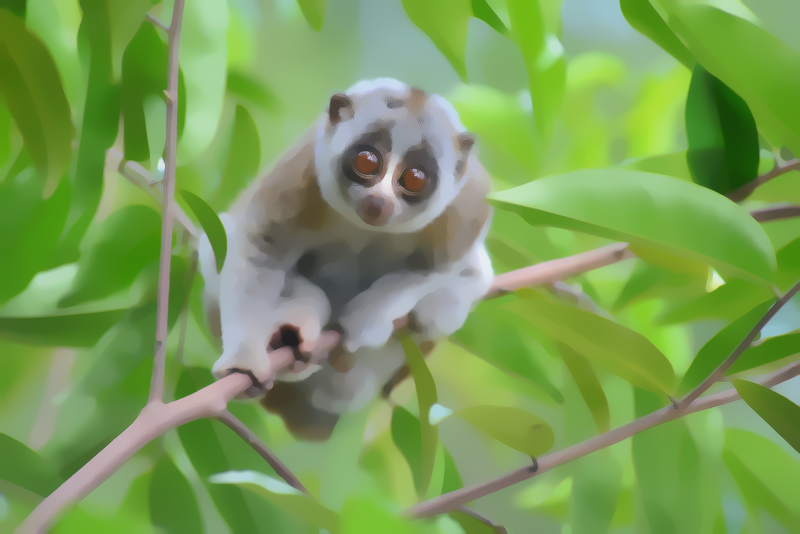

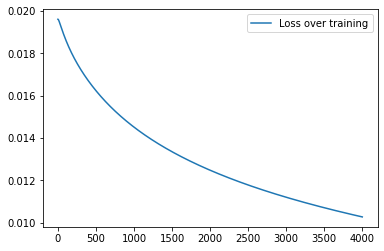

In [8]:
timestamp = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
new_dir = Path(f'C:/Users/aaros/Dropbox/fall quarter 2021/CSCD501/research project/code/notebooks/{timestamp}-notebook-out')
os.makedirs(new_dir)

smoother = SmoothWithOnlyRegressionModified(d_img)
loss = None
loss_hist = []
optimizer = torch.optim.SGD(smoother.parameters(), lr=5, momentum=0.9)
num_iters: int = 4000
for i in range(num_iters):
    optimizer.zero_grad()
    loss = smoother()

    if i % 50 == 0:
        print("Loss in iteration {} of {}: {:.3f}".format(i, num_iters, loss.item()))
        save_img = tensor_to_image(smoother.img.clone().detach())
        save_img.save(new_dir / f'img_iter_{i}.png')
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.clone().detach().cpu().numpy())

plt.plot(loss_hist)
plt.legend(['Loss over training', 'Edge loss'])
tensor_to_image(smoother.img, 'RGB')

In [7]:
class SmoothWithOnlyRegressionModified2(torch.nn.Module):
    # Less regression loss due to dividing by n
    def __init__(self, img, loss_weights=(1, 1, 1), sigma=2):
        super(SmoothWithOnlyRegressionModified2, self).__init__()
        self.img = torch.nn.Parameter(data=img.clone(), requires_grad=True)
        self.loss_weights = loss_weights
        self.sigma = sigma 
        self.guide_edges = K.filters.Canny(sigma=(self.sigma,self.sigma))(img)[1]
        self.conv_dt = K.contrib.ConvDistanceTransform(33)
        self.guide_edge_dt = self.conv_dt(self.guide_edges)
        
    def loss(self):
        xi_canny =  K.filters.Canny(sigma=(self.sigma,self.sigma))(self.img)[1]
        
        px_gradients = K.filters.sobel(self.img)
        long_edge = max(self.img.shape[2], self.img.shape[3])
        regression_loss = self.guide_edge_dt - self.conv_dt(self.img) / long_edge
        #edge_diff = self.guide_edges - xi_canny
                              
        return px_gradients.mean() + regression_loss.mean()
        ''
    def forward(self):
        return self.loss()

Loss in iteration 0 of 4500: 8.388
Loss in iteration 50 of 4500: 8.387
Loss in iteration 100 of 4500: 8.387
Loss in iteration 150 of 4500: 8.386
Loss in iteration 200 of 4500: 8.386
Loss in iteration 250 of 4500: 8.386
Loss in iteration 300 of 4500: 8.385
Loss in iteration 350 of 4500: 8.385
Loss in iteration 400 of 4500: 8.385
Loss in iteration 450 of 4500: 8.385
Loss in iteration 500 of 4500: 8.384
Loss in iteration 550 of 4500: 8.384
Loss in iteration 600 of 4500: 8.384
Loss in iteration 650 of 4500: 8.384
Loss in iteration 700 of 4500: 8.384
Loss in iteration 750 of 4500: 8.383
Loss in iteration 800 of 4500: 8.383
Loss in iteration 850 of 4500: 8.383
Loss in iteration 900 of 4500: 8.383
Loss in iteration 950 of 4500: 8.383
Loss in iteration 1000 of 4500: 8.383
Loss in iteration 1050 of 4500: 8.382
Loss in iteration 1100 of 4500: 8.382
Loss in iteration 1150 of 4500: 8.382
Loss in iteration 1200 of 4500: 8.382
Loss in iteration 1250 of 4500: 8.382
Loss in iteration 1300 of 4500: 8.3

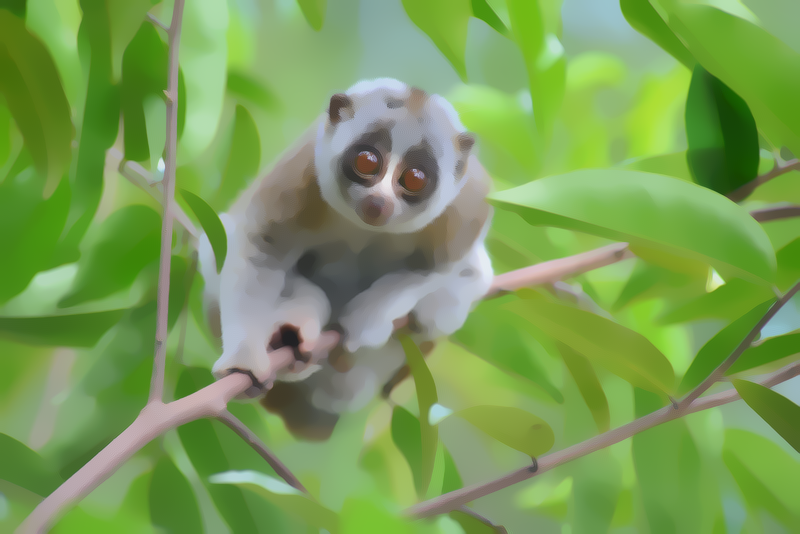

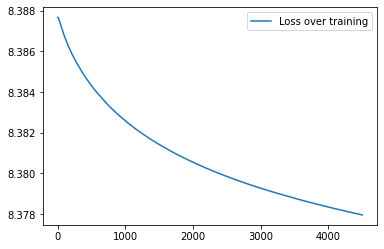

In [8]:
timestamp = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
new_dir = Path(f'C:/Users/aaros/Dropbox/fall quarter 2021/CSCD501/research project/code/notebooks/{timestamp}-notebook-out')
os.makedirs(new_dir)

smoother = SmoothWithOnlyRegressionModified2(d_img)
loss = None
loss_hist = []
optimizer = torch.optim.SGD(smoother.parameters(), lr=5, momentum=0.9)
num_iters: int = 4500
for i in range(num_iters):
    optimizer.zero_grad()
    loss = smoother()

    if i % 50 == 0:
        print("Loss in iteration {} of {}: {:.3f}".format(i, num_iters, loss.item()))
        save_img = tensor_to_image(smoother.img.clone().detach())
        save_img.save(new_dir / f'img_iter_{i}.png')
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.clone().detach().cpu().numpy())

plt.plot(loss_hist)
plt.legend(['Loss over training', 'Edge loss'])
tensor_to_image(smoother.img, 'RGB')

In [12]:
eps = 1e-12
B, C, H, W = 1, 1, 4, 4
input = torch.zeros(B, C, H, W)
input[0, 0, 0, 0] = 1.0
distance_transformer = K.contrib.ConvDistanceTransform(7)
output =  distance_transformer(input)
output

tensor([[[[0.0000, 1.0000, 2.0000, 3.0000],
          [1.0000, 1.4142, 2.2361, 3.1623],
          [2.0000, 2.2361, 2.8284, 3.6056],
          [3.0000, 3.1623, 3.6056, 4.2426]]]])

In [13]:
output[0, 0, H-1, 0]

tensor(3.0000)